In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import dask.dataframe as dd
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
import dask_ml.model_selection as dcv
from dask.distributed import Client
from sklearn.dummy import DummyClassifier, DummyRegressor

LOADING THE DATASETS

In [236]:
train_data1 = pd.read_csv("C:/Users/YADTECH/Documents/Data_science/Remote job search docs/Kaggle Project/train.csv")
rows_count = train_data1.shape[0]
rows_count

2122438

In [237]:
train_data1.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume', 'target'],
      dtype='object')

In [240]:
test_data1 = pd.read_csv("C:/Users/YADTECH/Documents/Data_science/Remote job search docs/Kaggle Project/test.csv")
row_count = test_data1.shape[0]
row_count

909617

In [241]:
test_data1.columns

Index(['row_id', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_volume',
       'taker_buy_quote_volume'],
      dtype='object')

In [242]:
train_data1.head()

,timestamp,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_volume,taker_buy_quote_volume,target
0,1525471260,0.90120,0.90130,0.90120,0.90130,134.98,121.646459,4.0,125.08,112.723589,1.0
1,1525471320,0.90185,0.90195,0.90185,0.90195,1070.54,965.505313,12.0,879.94,793.612703,0.0
2,1525471380,0.90140,0.90140,0.90139,0.90139,2293.06,2066.963991,5.0,0.00,0.000000,0.0
3,1525471440,0.90139,0.90140,0.90138,0.90139,6850.59,6175.000909,19.0,1786.30,1610.149485,0.0
4,1525471500,0.90139,0.90139,0.90130,0.90130,832.30,750.222624,3.0,784.82,707.428900,0.0


CHECKING THE STRUCTURES OF THE DATASETS

In [243]:
rows_with_missing_values = train_data1[train_data1.isnull()].sum()
rows_with_missing_values

timestamp                 0.0
open                      0.0
high                      0.0
low                       0.0
close                     0.0
volume                    0.0
quote_asset_volume        0.0
number_of_trades          0.0
taker_buy_base_volume     0.0
taker_buy_quote_volume    0.0
target                    0.0
dtype: float64

In [244]:
row_with_missing_values = test_data1[test_data1.isnull()].sum()
row_with_missing_values

row_id                    0.0
timestamp                 0.0
open                      0.0
high                      0.0
low                       0.0
close                     0.0
volume                    0.0
quote_asset_volume        0.0
number_of_trades          0.0
taker_buy_base_volume     0.0
taker_buy_quote_volume    0.0
dtype: float64

Efficiently Loading The Data

In [246]:
# Load the dataset using Dask for memory efficiency
train_data = dd.read_csv('C:/Users/YADTECH/Documents/Data_science/Remote job search docs/Kaggle Project/train.csv', dtype={
    'timestamp': 'int32', 'open': 'float32', 'high': 'float32',
    'low': 'float32', 'close': 'float32', 'volume': 'float32',
    'quote_asset_volume': 'float32', 'number_of_trades': 'float32',
    'taker_buy_base_volume': 'float32', 'taker_buy_quote_volume': 'float32',
    'target': 'float32'
})
# Compute Dask dataframe into a Pandas dataframe
train_data_pd = train_data.compute()

In [247]:
test_data_dd = dd.read_csv("C:/Users/YADTECH/Documents/Data_science/Remote job search docs/Kaggle Project/test.csv", dtype={
    'row_id': 'int32', 'timestamp': 'int32', 'open': 'float32', 'high': 'float32',
    'low': 'float32', 'close': 'float32', 'volume': 'float32',
    'quote_asset_volume': 'float32', 'number_of_trades': 'float32',
    'taker_buy_base_volume': 'float32', 'taker_buy_quote_volume': 'float32'
}
)
# Compute Dask dataframe into a Pandas dataframe
test_data = test_data_dd.compute()

Memory Optimization

In [248]:
 #Reduce data types and convert categorical columns
train_data_pd['target'] = train_data_pd['target'].astype('category')

Sampling For Initial Testing

In [249]:
# For faster iterations, sample 70% of the dataset

# Stratified sampling
train_data_sample = train_data_pd.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.7, random_state=42))

FEATURE ENGINEERING

In [250]:
# Feature Engineering: Calculate new features for the training data
train_data_sample['price_change'] = train_data_sample['close'] - train_data_sample['open']
train_data_sample['volatility'] = (train_data_sample['high'] - train_data_sample['low']) / train_data_sample['open']
train_data_sample['volume_change'] = train_data_sample['taker_buy_base_volume'] / train_data_sample['volume']

# Add moving averages, lag, and rolling standard deviation features
train_data_sample['rolling_mean_close'] = train_data_sample['close'].rolling(window=5).mean()
train_data_sample['rolling_std_close'] = train_data_sample['close'].rolling(window=5).std()
train_data_sample['lag_close'] = train_data_sample['close'].shift(1)
train_data_sample['lag_volume'] = train_data_sample['volume'].shift(1)

# Fill NaN values created by rolling/shift functions
train_data_sample= train_data_sample.fillna(0)

# Drop unnecessary columns for model training
train_data_sample = train_data_sample.drop(columns=['timestamp'])


# Feature engineering for the test data
test_data['price_change'] = test_data['close'] - test_data['open']
test_data['volatility'] = (test_data['high'] - test_data['low']) / test_data['open']
test_data['volume_change'] = test_data['taker_buy_base_volume'] / test_data['volume']
test_data['rolling_mean_close'] = test_data['close'].rolling(window=5).mean()
test_data['rolling_std_close'] = test_data['close'].rolling(window=5).std()
test_data['lag_close'] = test_data['close'].shift(1)
test_data['lag_volume'] = test_data['volume'].shift(1)

# Fill NaN values created by rolling/shift functions
test_data = test_data.fillna(0)

# Drop unnecessary columns in the test data
test_data = test_data.drop(columns=['timestamp', 'row_id'])



In [251]:
# Split data into features and target
X = train_data_sample.drop(columns=['target'])
y = train_data_sample['target']


HANDLING IMBALANCING

In [252]:

# Apply SMOTE to balance classes
# sm = SMOTE(random_state=42)
# sm = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=3)
# X_resampled, y_resampled = sm.fit_resample(X, y)

# from imblearn.combine import SMOTEENN

# # Apply SMOTE with ENN (Edited Nearest Neighbors) to balance classes
# smote_enn = SMOTEENN(random_state=42)
# X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# # Check the class distribution after applying SMOTE+ENN
# print("After SMOTE+ENN:", y_resampled)



Time-series split for cross-validation

In [253]:
tscv = TimeSeriesSplit(n_splits=5)
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

LightGBM Model with Hyperparameter Tuning (RandomizedSearchCV)

In [254]:
# Initialize LightGBM model with basic parameters
lgb_model = lgb.LGBMClassifier(
    num_leaves=50,         
    learning_rate=0.1,     
    scale_pos_weight=20,     
    random_state=4,
)

# Fit the model on the training data
lgb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_lgb = lgb_model.predict(X_val)

# Evaluate LightGBM
f1_lgb = f1_score(y_val, y_pred_lgb, average='macro')
precision_lgb = precision_score(y_val, y_pred_lgb, average='macro')
recall_lgb = recall_score(y_val, y_pred_lgb, average='macro')
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)

print(f"LightGBM Metrics - F1 Score: {f1_lgb}, Precision: {precision_lgb}, Recall: {recall_lgb}, Accuracy: {accuracy_lgb}")

[LightGBM] [Info] Number of positive: 459260, number of negative: 778830
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.213475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 1238090, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.370942 -> initscore=-0.528176
[LightGBM] [Info] Start training from score -0.528176
LightGBM Metrics - F1 Score: 0.4999727386729186, Precision: 0.5, Recall: 0.4999454803183949, Accuracy: 0.9998909606367898


c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


HYPERPARAMETER TUNING FOR LightGBM

In [255]:
# Define the parameter distribution for LightGBM
param_dist_lgb = {
    'num_leaves': range(20, 100, 10),
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'scale_pos_weight': [1, 5, 10, 20]
}

# Initialize the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)

# Randomized Search with fewer iterations and single-threaded execution
random_search_lgb = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=20,              
    scoring='f1',           
    cv=tscv,               
    random_state=42,
    verbose=2,         
    n_jobs=1                
)

# Fit the model on the training data
random_search_lgb.fit(X_train, y_train)

# Predict on the validation set
y_pred_lgb = random_search_lgb.predict(X_val)

# Evaluate the model using F1 score, precision, recall, and accuracy
f1_lgb = f1_score(y_val, y_pred_lgb, average='macro')
precision_lgb = precision_score(y_val, y_pred_lgb, average='macro')
recall_lgb = recall_score(y_val, y_pred_lgb, average='macro')
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)

# Print the evaluation metrics
print(f"LightGBM Metrics - F1 Score: {f1_lgb}, Precision: {precision_lgb}, Recall: {recall_lgb}, Accuracy: {accuracy_lgb}")



Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 206350
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 206350, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the sp

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=70, scale_pos_weight=20; total time=   1.1s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.084062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=70, scale_pos_weight=20; total time=   2.0s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=40, scale_pos_weight=1; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067545 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=40, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[L

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=60, scale_pos_weight=20; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=60, scale_pos_weight=20; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=90, scale_pos_weight=20; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=90, scale_pos_weight=20; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.119551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=20, scale_pos_weight=10; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=20, scale_pos_weight=10; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.100836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=80, scale_pos_weight=1; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[L

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=80, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088921 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=30, scale_pos_weight=5; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=30, scale_pos_weight=5; total time=   1.1s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.102093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=40, scale_pos_weight=1; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=40, scale_pos_weight=1; total time=   1.5s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.115927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=60, scale_pos_weight=5; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.076609 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=60, scale_pos_weight=5; total time=   1.3s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.103100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=80, scale_pos_weight=10; total time=   1.3s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.073295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=80, scale_pos_weight=10; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.124970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=90, scale_pos_weight=10; total time=   1.0s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=90, scale_pos_weight=10; total time=   1.4s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=80, scale_pos_weight=20; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=80, scale_pos_weight=20; total time=   1.3s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more l

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=20, scale_pos_weight=1; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=20, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=30, scale_pos_weight=1; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.01, num_leaves=30, scale_pos_weight=1; total time=   1.3s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=20, scale_pos_weight=1; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.064228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=20, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=60, scale_pos_weight=5; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=60, scale_pos_weight=5; total time=   1.4s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=30, scale_pos_weight=1; total time=   0.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.05, num_leaves=30, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more le

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=60, scale_pos_weight=1; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085348 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=60, scale_pos_weight=1; total time=   1.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=90, scale_pos_weight=5; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.2, num_leaves=90, scale_pos_weight=5; total time=   1.2s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=70, scale_pos_weight=1; total time=   0.9s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 412698
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.134763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 412698, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more lea

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


[CV] END learning_rate=0.1, num_leaves=70, scale_pos_weight=1; total time=   1.8s
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 619046
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4080
[LightGBM] [Info] Number of data points in the train set: 619046, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Model

In [256]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.2,
    scale_pos_weight=5,  
    random_state=42,
    objective='binary:logistic',
    eval_metric='logloss'
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_xgb = xgb_model.predict(X_val)

# Evaluate XGBoost
f1_xgb = f1_score(y_val, y_pred_xgb, average='macro')
precision_xgb = precision_score(y_val, y_pred_xgb, average='macro')
recall_xgb = recall_score(y_val, y_pred_xgb, average='macro')
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)

print(f"XGBoost Metrics - F1 Score: {f1_xgb}, Precision: {precision_xgb}, Recall: {recall_xgb}, Accuracy: {accuracy_xgb}")

XGBoost Metrics - F1 Score: 0.49816282647070154, Precision: 0.5, Recall: 0.4963391043425936, Accuracy: 0.9926782086851872


c:\Users\YADTECH\Documents\Data_science\Remote job search docs\Kaggle Project\myenv\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Predict on the test data using the best model (e.g., Stacking)

In [260]:
# X_test = test_data.drop(columns=['timestamp', 'row_id']).compute()
test_predictions = random_search_lgb.predict(test_data)

# Create submission DataFrame
submission = pd.DataFrame({'row_id': test_data1['row_id'], 'target': test_predictions})
submission.to_csv('submission.csv', index=False)

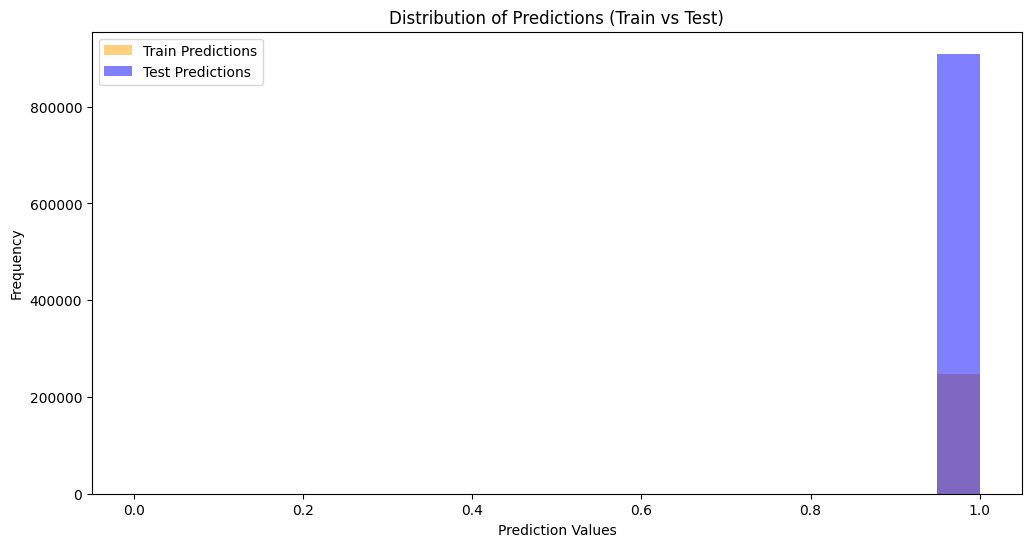

In [257]:
# Compare prediction distribution between training and test sets
plt.figure(figsize=(12, 6))

# Histogram of predictions on training data
plt.hist(y_pred_lgb, bins=20, alpha=0.5, label="Train Predictions", color='orange')

# Histogram of predictions on test data
plt.hist(test_predictions, bins=20, alpha=0.5, label="Test Predictions", color='blue')

plt.xlabel("Prediction Values")
plt.ylabel("Frequency")
plt.title("Distribution of Predictions (Train vs Test)")
plt.legend()
plt.show()


In [258]:
# Initialize a baseline model
if hasattr(y_pred_lgb, "predict_proba"):  # Classification task
    baseline_model = DummyClassifier(strategy="most_frequent")
    baseline_model.fit(X_train, y_train)
    baseline_predictions = baseline_model.predict(test_predictions)
    
    print("Baseline Predictions (Dummy Classifier):", baseline_predictions[:10])

else:  # Regression task
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train, y_train)
    baseline_predictions = baseline_model.predict(test_predictions)
    
    print("Baseline Predictions (Dummy Regressor):", baseline_predictions[:10])




Baseline Predictions (Dummy Regressor): [0.37094234 0.37094234 0.37094234 0.37094234 0.37094234 0.37094234
 0.37094234 0.37094234 0.37094234 0.37094234]
